In [1]:
import os
import sys
sys.path.append('../megaDNA')
import yaml
import torch
import torch.nn as nn
import random
import numpy as np
from tqdm import tqdm
from stripedhyena.model import StripedHyena
from stripedhyena.utils import dotdict
from megadna import MEGADNA

/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nucleotides = ['**', 'A', 'T', 'C', 'G', '#'] # vocabulary
PRIME_LENGTH = 4 # give the model a random DNA primer to start
num_seq = 200 # number of runs
context_length = 50000 # maximal length for the generated sequence, depend on your GPU memory
config_path = "config/hyena.yml"
#checkpoint_path = "checkpoint/evo_model_epoch_4.pt"
#checkpoint_path = "../megadna_trained_model/megadna_model_epoch_5.pt" 
# # 定义所有.pt文件路径
# checkpoint_paths = [
#     "../megadna_trained_model/megadna_model_epoch_5.pt",
#     "../megadna_trained_model/megadna_model_epoch_10.pt", 
#     "../megadna_trained_model/megadna_model_epoch_15.pt",
#     "../megadna_trained_model/megadna_model_epoch_20.pt",
#     "../megadna_trained_model/megadna_model_epoch_25.pt",
#     "../megadna_trained_model/megadna_model_epoch_30.pt",
#     "../megadna_trained_model/megadna_model_epoch_35.pt",
#     "../megadna_trained_model/megadna_model_epoch_40.pt",
#     "../megadna_trained_model/megadna_model_epoch_45.pt"
# ]
checkpoint_paths = [
    "../megadna_trained_model/megadna_model_epoch_1.pt",
    "../megadna_trained_model/megadna_model_epoch_2.pt", 
    "../megadna_trained_model/megadna_model_epoch_3.pt",
    "../megadna_trained_model/megadna_model_epoch_4.pt",
    "../megadna_trained_model/megadna_model_epoch_5.pt"
]
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#print(checkpoint_paths[0])

In [4]:
# print(f"Loading configuration from {config_path}...")
# with open(config_path, 'r') as f:
#     config = yaml.safe_load(f)

# model_config = dotdict(config)
# model = StripedHyena(model_config)
model = MEGADNA(
    num_tokens=6,           # 与nucleotides列表长度一致
    dim=512,                # 模型维度
    depth=(8, 4),           # 两层结构
    max_seq_len=(8192, 32)  # 最大序列长度
   )
print("Model instance created successfully.")

print(f"Loading checkpoint from {checkpoint_path}...")
# Load the entire checkpoint dictionary
checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])

print("Model weights loaded into the instance.")
# torch.save(model.state_dict(), 'stripedhyena_phage.pt')
model.eval()
model.to(device)
model = model.to(torch.float32)
print(f"Model is loaded on {device} and in evaluation mode.")
print(model)

Model instance created successfully.
Loading checkpoint from ../megadna_trained_model/megadna_model_epoch_5.pt...
Model weights loaded into the instance.
Model is loaded on cpu and in evaluation mode.
MEGADNA(
  (start_tokens): ParameterList(
      (0): Parameter containing: [torch.float32 of size 512]
      (1): Parameter containing: [torch.float32 of size 512]
  )
  (token_embs): ModuleList(
    (0): Embedding(6, 512)
    (1): Sequential(
      (0): Embedding(6, 512)
      (1): Rearrange('... r d -> ... (r d)')
      (2): LayerNorm((16384,), eps=1e-05, elementwise_affine=True)
      (3): Linear(in_features=16384, out_features=512, bias=True)
      (4): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (transformers): ModuleList(
    (0): Transformer(
      (layers): ModuleList(
        (0-7): 8 x ModuleList(
          (0): Attention(
            (attend): Attend(
              (attn_dropout): Dropout(p=0.0, inplace=False)
            )
            (dropout): Dropout(p

In [5]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

from Bio import SeqIO
# fasta_file_path = "combined_contigs_virus_filtered_96K_sampled_200_virus.fna"
fasta_file_path = "lambda_phage_NC_001416.1.fasta"
# Define the nucleotide list
nt = ['**', 'A', 'T', 'C', 'G', '#']

# Lists to store sequence IDs and sequences
seq_ids = []
sequences = []

# # Read the FASTA file
with open(fasta_file_path, "r") as fasta_file:
    for record in SeqIO.parse(fasta_file, "fasta"):
        seq_ids.append(record.id)
        sequences.append(str(record.seq))

Number of parameters: 38433792


In [3]:
def calculate_loss_in_chunks(sequence_str, chunk_size, model, nt_map, criterion, device):
    # all_logits = []
    # all_targets = []
    total_loss = 0
    chunk_count = 0
    model.eval()
    
    with torch.no_grad():
        for i in range(0, len(sequence_str), chunk_size):
            chunk_str_slice = sequence_str[i : i + chunk_size]
            if not chunk_str_slice:
                continue

            tokens = torch.tensor(
                [0] + [nt_map.index(nuc) if nuc in nt_map else 1 for nuc in chunk_str_slice] + [5]
            ).to(device)
            
            x = tokens[:-1].unsqueeze(0)
            
            # MEGADNA 直接返回损失
            chunk_loss = model(x, return_value='loss')
            total_loss += chunk_loss.item()
            chunk_count += 1

    if chunk_count == 0:
        return 0
    
    return total_loss / chunk_count  # 返回平均损失
            
    #         x = tokens[:-1].unsqueeze(0)
    #         y = tokens[1:].unsqueeze(0)
    #         logits, _ = model(x)
            
    #         all_logits.append(logits.cpu())
    #         all_targets.append(y.cpu())

    # full_logits = torch.cat(all_logits, dim=1).to(device)
    # full_targets = torch.cat(all_targets, dim=1).to(device)
    
    # loss = criterion(full_logits.view(-1, full_logits.size(-1)), full_targets.view(-1))
    # return loss.item()

In [7]:
criterion = nn.CrossEntropyLoss()
baseline_loss = calculate_loss_in_chunks(sequences[0] , 8192, model, nucleotides, criterion, device)
print(f"Baseline Loss: {baseline_loss:.4f}")

/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Baseline Loss: 1.3810


In [8]:
loss_all = []
step = 50
num_steps = len(sequences[0]) // step

for j in tqdm(range(num_steps - 1), desc="Mutational Scanning"):
    
    mutated_sequence_list = list(sequences[0])
    
    start_index = 1 + j * step
    end_index = start_index + step
    for i in range(start_index, end_index):
        if i < len(mutated_sequence_list):
            mutated_sequence_list[i] = random.choice(['A', 'T', 'C', 'G'])
    
    mutated_sequence_str = "".join(mutated_sequence_list)
    
    mutated_loss = calculate_loss_in_chunks(mutated_sequence_str, 8192, model, nucleotides, criterion, device)
    
    loss_change = mutated_loss
    loss_all.append(loss_change)

Mutational Scanning: 100%|██████████| 969/969 [07:03<00:00,  2.29it/s]


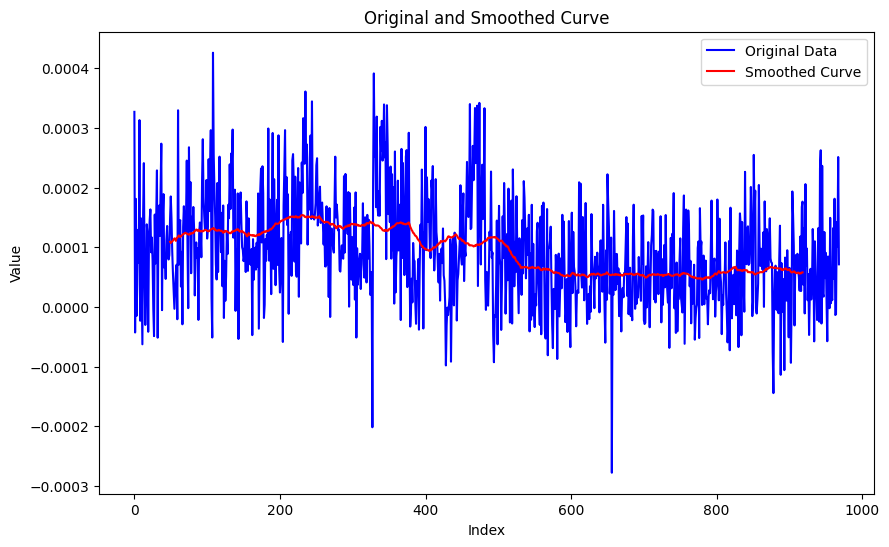

In [9]:
import matplotlib.pyplot as plt
# plt.plot(np.array(loss_all)-3.4359/3.3096/3.2277/3.0402/2.7094/2.8537/2.7703/2.7505/)
# plt.show()

# data_array = np.array(loss_all)-2.0319
data_array = np.array(loss_all)-1.3810
np.savetxt("20240116_lambda_phage_mutation_step50.txt", data_array)
# Define the size of the moving window for smoothing
window_size = 100

# Compute the moving window average
smoothed_data = np.convolve(data_array, np.ones(window_size)/window_size, mode='valid')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data_array, label='Original Data', color='blue')
plt.plot(range(int(window_size/2)-1, len(data_array)-int(window_size/2)), smoothed_data, label='Smoothed Curve', color='red')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Original and Smoothed Curve')
plt.legend()
plt.show()

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in indexes: http://mirrors.aliyun.com/pypi/simple


(array([0.    , 0.0005, 0.001 , 0.0015]),
 [Text(0, 0.0, '0.0000'),
  Text(0, 0.0005, '0.0005'),
  Text(0, 0.001, '0.0010'),
  Text(0, 0.0015, '0.0015')])

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

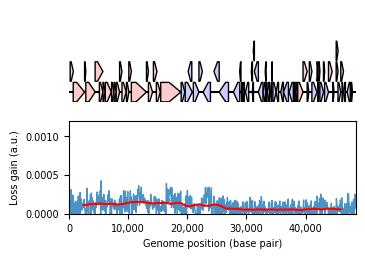

In [10]:
! pip install dna_features_viewer
! pip install bcbio-gff
! pip install bcbio-nextgen

from BCBio import GFF
import matplotlib.pyplot as plt
import numpy as np
from dna_features_viewer import GraphicFeature, GraphicRecord

import matplotlib

# Setting global font properties
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.size'] = 7

data_array = np.loadtxt("20240116_lambda_phage_mutation_step50.txt")
step = 50
# in_handle = open("../megaDNA/NC_001416.1.gff3")
in_handle = open("../lambda_phage_NC_001416.1.gff3")
features = []

data_essential = []
data_nonessential = []
start_position = []
end_position = []
strand_position=[]
# essential_genes = ['N', 'O', 'P', 'Q', "S'",'cro', 'ren', 'NinB', 'NinC',\
#                   'NinF','NinG', 'NinI', 'S', 'Rz']
essential_genes = ['N', 'O', 'P', 'Q', "S'",'cro', 'S', 'Rz']
limit_info = dict(gff_type=["CDS"])  #只解析编码序列

mean_loss = []
gene_essent = []
for rec in GFF.parse(in_handle, limit_info=limit_info):
    for j in range(len(rec.features)):  #这里rec.features只包含CDS类型的特征，不会包含gene、mRNA等其他类型
#         print(rec.features[j].location.start)
#         print(rec.features[j].location.end)
#         print(rec.features[j].location.strand)
        if "gene" in rec.features[j].qualifiers.keys():
            gene_name = rec.features[j].qualifiers["gene"][0]
        else:
            gene_name = "''"
        gene_color = "#ccccff"
#         gene_color = "#ffffff"
        if rec.features[j].location.end < 19000:
            gene_color = "#ffcccc"#"#ff0200"
        if gene_name in essential_genes:
            gene_color = "#ffcccc" #"#ffcccc"

        start_position.append(rec.features[j].location.start)
        end_position.append(rec.features[j].location.end)
        strand_position.append(rec.features[j].location.strand)

        gene_start = int(rec.features[j].location.start/step)+1
        gene_end = int(rec.features[j].location.end/step) + 1
        if gene_color == "#ffcccc":
            data_essential.extend(list(data_array[gene_start:gene_end]))
            gene_essent.append(1)
        else:
            data_nonessential.extend(list(data_array[gene_start:gene_end]))
            gene_essent.append(0)
            
        mean_loss.append(np.mean(data_array[gene_start:gene_end]))
        features.append(GraphicFeature(start=rec.features[j].location.start, \
                                       end=rec.features[j].location.end, \
                                       strand=rec.features[j].location.strand, \
                                       color=gene_color))

window_size = 100
# Compute the moving window average
smoothed_data = np.convolve(data_array, np.ones(window_size)/window_size, mode='valid')

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(3.7, 2.65), sharex=True, gridspec_kw={"height_ratios": [2, 2]}
)
record = GraphicRecord(sequence_length=48502, features=features)
record.plot(ax=ax1, with_ruler=False,strand_in_label_threshold=2000000)
ax2.plot(np.arange(len(data_array))*step + step/2, data_array, label='Original Data', linewidth = 1,alpha = 0.8)
ax2.plot(np.array(range(int(window_size/2)-1, len(data_array)-int(window_size/2)))*step + step/2, smoothed_data, label='Smoothed Curve', color='red')
ax2.set_ylim([0, 0.0012])
# ax2.set_yscale('log')
ax2.set_ylabel("Loss gain (a.u.)", fontsize = 7)
ax2.set_xlabel("Genome position (base pair)", fontsize = 7)
ax2.set_xticks(np.arange(0, 45001, 10000)) 
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
# save_path = "C://Broad//MegaDNA paper//figures//essential_non_essentail_genome.eps"
# plt.savefig(save_path, bbox_inches='tight')
# save_path = "C://Broad//MegaDNA paper//figures//essential_non_essentail_genome.png"
# plt.savefig(save_path, bbox_inches='tight', dpi=600)

In [19]:
print(sum(gene_essent), len(gene_essent))
for j in (np.arange(len(data_array))*step + step/2):
    print(j)

for j in data_array:
    print(j)

29 73
25.0
75.0
125.0
175.0
225.0
275.0
325.0
375.0
425.0
475.0
525.0
575.0
625.0
675.0
725.0
775.0
825.0
875.0
925.0
975.0
1025.0
1075.0
1125.0
1175.0
1225.0
1275.0
1325.0
1375.0
1425.0
1475.0
1525.0
1575.0
1625.0
1675.0
1725.0
1775.0
1825.0
1875.0
1925.0
1975.0
2025.0
2075.0
2125.0
2175.0
2225.0
2275.0
2325.0
2375.0
2425.0
2475.0
2525.0
2575.0
2625.0
2675.0
2725.0
2775.0
2825.0
2875.0
2925.0
2975.0
3025.0
3075.0
3125.0
3175.0
3225.0
3275.0
3325.0
3375.0
3425.0
3475.0
3525.0
3575.0
3625.0
3675.0
3725.0
3775.0
3825.0
3875.0
3925.0
3975.0
4025.0
4075.0
4125.0
4175.0
4225.0
4275.0
4325.0
4375.0
4425.0
4475.0
4525.0
4575.0
4625.0
4675.0
4725.0
4775.0
4825.0
4875.0
4925.0
4975.0
5025.0
5075.0
5125.0
5175.0
5225.0
5275.0
5325.0
5375.0
5425.0
5475.0
5525.0
5575.0
5625.0
5675.0
5725.0
5775.0
5825.0
5875.0
5925.0
5975.0
6025.0
6075.0
6125.0
6175.0
6225.0
6275.0
6325.0
6375.0
6425.0
6475.0
6525.0
6575.0
6625.0
6675.0
6725.0
6775.0
6825.0
6875.0
6925.0
6975.0
7025.0
7075.0
7125.0
7175.0
7225.0
7

73 73


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

0.7648902821316614


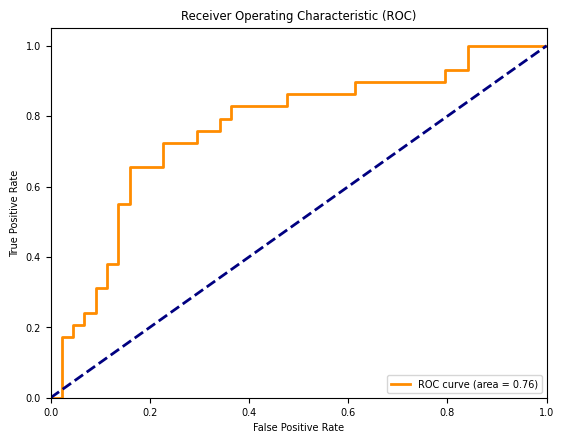

In [12]:
# ! pip install -U scikit-learn
print(len(mean_loss), len(gene_essent))
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

pred = mean_loss  # Your prediction array
y = gene_essent     # Your true labels array

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y, pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


处理第 1/9 个模型: ../megadna_trained_model/megadna_model_epoch_5.pt
Baseline Loss: 1.3347


Mutational Scanning for epoch 1: 100%|██████████| 969/969 [01:31<00:00, 10.64it/s]



处理第 2/9 个模型: ../megadna_trained_model/megadna_model_epoch_10.pt


/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Baseline Loss: 1.3791


Mutational Scanning for epoch 2: 100%|██████████| 969/969 [01:32<00:00, 10.52it/s]



处理第 3/9 个模型: ../megadna_trained_model/megadna_model_epoch_15.pt


/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Baseline Loss: 2.0228


Mutational Scanning for epoch 3: 100%|██████████| 969/969 [01:31<00:00, 10.57it/s]



处理第 4/9 个模型: ../megadna_trained_model/megadna_model_epoch_20.pt


/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Baseline Loss: 3.4877


Mutational Scanning for epoch 4: 100%|██████████| 969/969 [01:32<00:00, 10.49it/s]



处理第 5/9 个模型: ../megadna_trained_model/megadna_model_epoch_25.pt


/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Baseline Loss: 4.7919


Mutational Scanning for epoch 5: 100%|██████████| 969/969 [01:32<00:00, 10.43it/s]



处理第 6/9 个模型: ../megadna_trained_model/megadna_model_epoch_30.pt


/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Baseline Loss: 5.5202


Mutational Scanning for epoch 6: 100%|██████████| 969/969 [01:32<00:00, 10.52it/s]



处理第 7/9 个模型: ../megadna_trained_model/megadna_model_epoch_35.pt


/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Baseline Loss: 5.8137


Mutational Scanning for epoch 7: 100%|██████████| 969/969 [01:33<00:00, 10.38it/s]



处理第 8/9 个模型: ../megadna_trained_model/megadna_model_epoch_40.pt


/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Baseline Loss: 6.0926


Mutational Scanning for epoch 8: 100%|██████████| 969/969 [01:32<00:00, 10.48it/s]



处理第 9/9 个模型: ../megadna_trained_model/megadna_model_epoch_45.pt


/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Baseline Loss: 6.3317


Mutational Scanning for epoch 9: 100%|██████████| 969/969 [01:32<00:00, 10.46it/s]


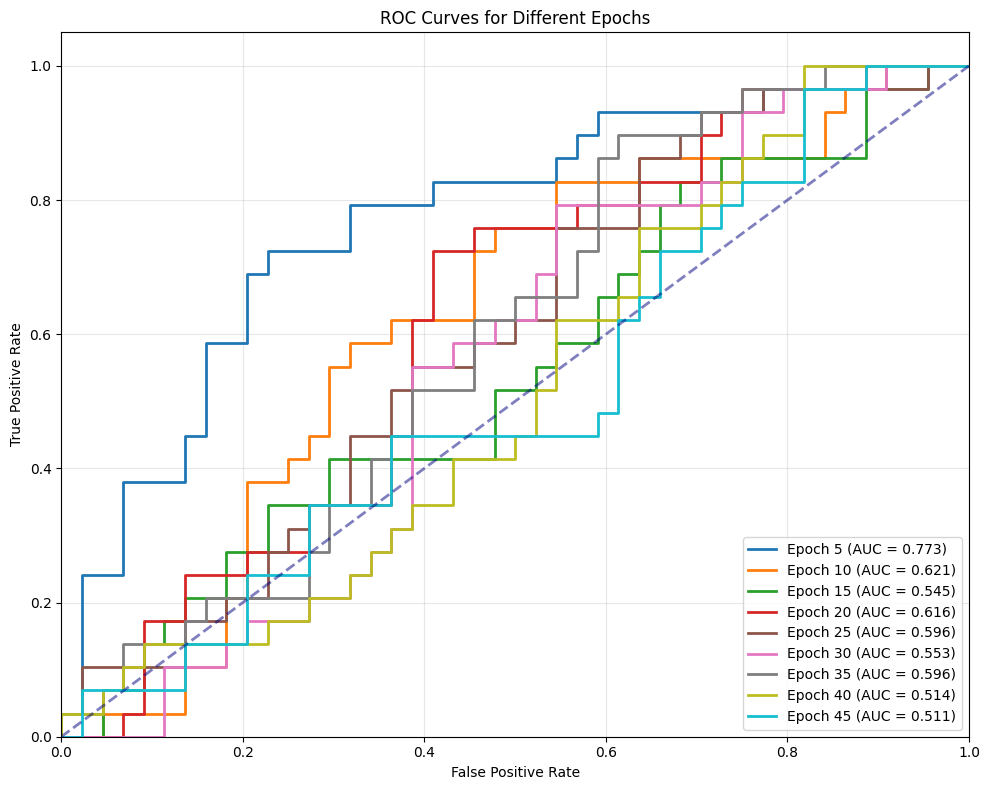


所有模型ROC曲线绘制完成！


In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import random
import yaml
from tqdm import tqdm
from BCBio import GFF
from dna_features_viewer import GraphicFeature, GraphicRecord
from Bio import SeqIO

# 定义dotdict类
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

# 配置参数
nucleotides = ['**', 'A', 'T', 'C', 'G', '#']
fasta_file_path = "lambda_phage_NC_001416.1.fasta"
gff_file_path = "lambda_phage_NC_001416.1.gff3"
essential_genes = ['N', 'O', 'P', 'Q', "S'", 'cro', 'S', 'Rz']
step = 50
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# 读取FASTA序列
seq_ids = []
sequences = []
with open(fasta_file_path, "r") as fasta_file:
    for record in SeqIO.parse(fasta_file, "fasta"):
        seq_ids.append(record.id)
        sequences.append(str(record.seq))

# # 加载模型配置
# with open(config_path, 'r') as f:
#     config = yaml.safe_load(f)
# model_config = dotdict(config)

# 设置绘图
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(checkpoint_paths)))

# 循环处理每个模型
for idx, checkpoint_path in enumerate(checkpoint_paths):
    print(f"\n处理第 {idx+1}/{len(checkpoint_paths)} 个模型: {checkpoint_path}")
    
    # 加载模型
    # model = StripedHyena(model_config)
    model = MEGADNA(
    num_tokens=6,           # 与nucleotides列表长度一致
    dim=512,                # 模型维度
    depth=(8, 4),           # 两层结构
    max_seq_len=(8192, 32)  # 最大序列长度
   )
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model.to(device)
    model = model.to(torch.float32)
    
    # 计算基线损失
    criterion = nn.CrossEntropyLoss()
    baseline_loss = calculate_loss_in_chunks(sequences[0], 8192, model, nucleotides, criterion, device)
    print(f"Baseline Loss: {baseline_loss:.4f}")
    
    # 突变扫描 - 生成当前模型的loss_all
    loss_all = []
    num_steps = len(sequences[0]) // step
    
    for j in tqdm(range(num_steps - 1), desc=f"Mutational Scanning for epoch {idx+1}"):
        mutated_sequence_list = list(sequences[0])
        
        start_index = 1 + j * step
        end_index = start_index + step
        for i in range(start_index, end_index):
            if i < len(mutated_sequence_list):
                mutated_sequence_list[i] = random.choice(['A', 'T', 'C', 'G'])
        
        mutated_sequence_str = "".join(mutated_sequence_list)
        mutated_loss = calculate_loss_in_chunks(mutated_sequence_str, 8192, model, nucleotides, criterion, device)
        loss_all.append(mutated_loss)
    
    
    current_data_array = np.array(loss_all) - baseline_loss
    
    mean_loss = []
    gene_essent = []
    
    with open(gff_file_path, "r") as in_handle:  # 每次循环重新打开文件
        limit_info = dict(gff_type=["CDS"])
        
        for rec in GFF.parse(in_handle, limit_info=limit_info):
            for j in range(len(rec.features)):
                # 获取基因名称
                if "gene" in rec.features[j].qualifiers.keys():
                    gene_name = rec.features[j].qualifiers["gene"][0]
                else:
                    gene_name = "''"
                
                # 基因分类
                gene_color = "#ccccff"
                if rec.features[j].location.end < 19000:
                    gene_color = "#ffcccc"
                if gene_name in essential_genes:
                    gene_color = "#ffcccc"
                
                # 计算基因对应的数据索引
                gene_start = int(rec.features[j].location.start / step) + 1
                gene_end = int(rec.features[j].location.end / step) + 1
                
                # 确保索引不越界
                gene_start = max(0, min(gene_start, len(current_data_array)))
                gene_end = max(0, min(gene_end, len(current_data_array)))
                
                if gene_start < gene_end:  # 确保有有效数据
                    # 使用当前模型的current_data_array，而不是固定的data_array
                    gene_mean_loss = np.mean(current_data_array[gene_start:gene_end])
                    mean_loss.append(gene_mean_loss)
                    
                    # 记录基因类型
                    if gene_color == "#ffcccc":
                        gene_essent.append(1)  # 必需基因
                    else:
                        gene_essent.append(0)  # 非必需基因
    
    # 检查是否满足ROC计算条件
    if len(gene_essent) == 0:
        print(f"  警告: 没有找到任何基因，跳过ROC计算")
        continue
        
    if len(set(gene_essent)) < 2:
        print(f"  警告: 只有一种基因类别({set(gene_essent)})，无法计算ROC曲线")
        continue
    
    # 计算ROC曲线
    pred = mean_loss
    y = gene_essent
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    
    # 获取epoch号用于图例
    epoch_num = checkpoint_path.split('_')[-1].split('.')[0]
    
    # 绘制ROC曲线
    plt.plot(fpr, tpr, color=colors[idx], lw=2, 
             label=f'Epoch {epoch_num} (AUC = {roc_auc:.3f})')

# 完善图表
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Epochs')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n所有模型ROC曲线绘制完成！")


处理第 1/5 个模型: ../megadna_trained_model/megadna_model_epoch_1.pt
Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Baseline Loss: 1.3563


Mutational Scanning for epoch 1: 100%|██████████| 969/969 [01:29<00:00, 10.83it/s]



处理第 2/5 个模型: ../megadna_trained_model/megadna_model_epoch_2.pt


/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Baseline Loss: 1.3387


Mutational Scanning for epoch 2: 100%|██████████| 969/969 [01:30<00:00, 10.75it/s]



处理第 3/5 个模型: ../megadna_trained_model/megadna_model_epoch_3.pt


/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Baseline Loss: 1.3370


Mutational Scanning for epoch 3: 100%|██████████| 969/969 [01:30<00:00, 10.75it/s]



处理第 4/5 个模型: ../megadna_trained_model/megadna_model_epoch_4.pt


/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Baseline Loss: 1.3363


Mutational Scanning for epoch 4: 100%|██████████| 969/969 [01:30<00:00, 10.71it/s]



处理第 5/5 个模型: ../megadna_trained_model/megadna_model_epoch_5.pt


/root/miniconda3/envs/evophage_env/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Baseline Loss: 1.3347


Mutational Scanning for epoch 5: 100%|██████████| 969/969 [01:30<00:00, 10.69it/s]


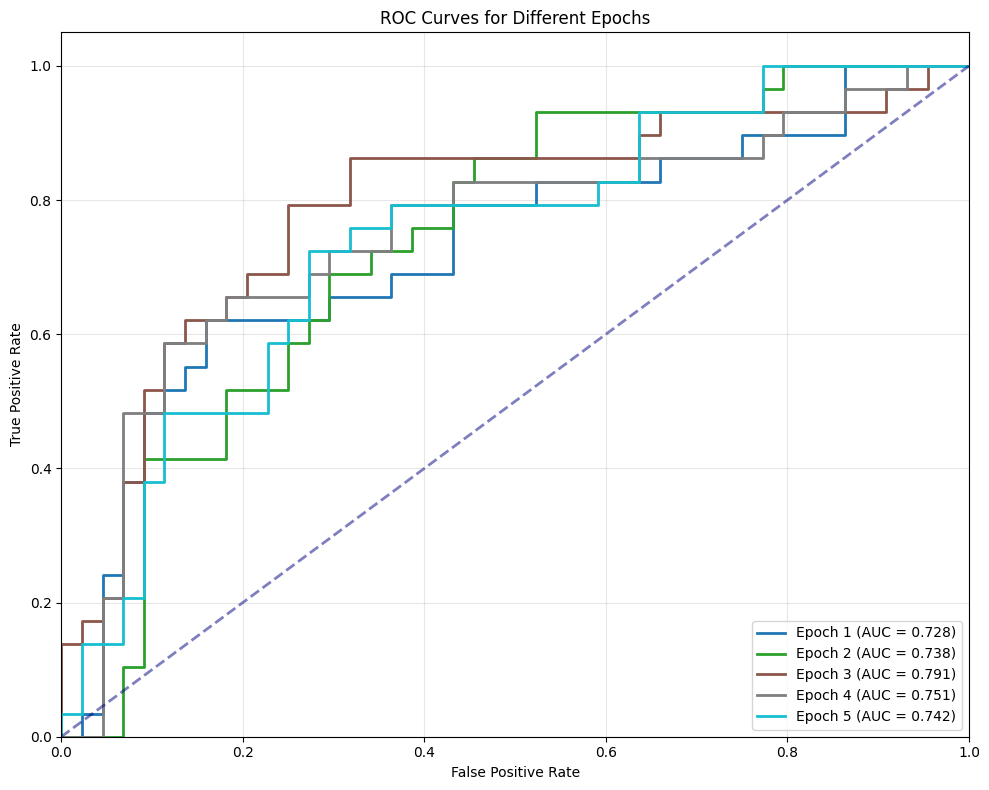


所有模型ROC曲线绘制完成！


In [4]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import random
import yaml
from tqdm import tqdm
from BCBio import GFF
from dna_features_viewer import GraphicFeature, GraphicRecord
from Bio import SeqIO

# 定义dotdict类
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

# 配置参数
nucleotides = ['**', 'A', 'T', 'C', 'G', '#']
fasta_file_path = "lambda_phage_NC_001416.1.fasta"
gff_file_path = "lambda_phage_NC_001416.1.gff3"
essential_genes = ['N', 'O', 'P', 'Q', "S'", 'cro', 'S', 'Rz']
step = 50
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# 读取FASTA序列
seq_ids = []
sequences = []
with open(fasta_file_path, "r") as fasta_file:
    for record in SeqIO.parse(fasta_file, "fasta"):
        seq_ids.append(record.id)
        sequences.append(str(record.seq))

# # 加载模型配置
# with open(config_path, 'r') as f:
#     config = yaml.safe_load(f)
# model_config = dotdict(config)

# 设置绘图
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(checkpoint_paths)))

# 循环处理每个模型
for idx, checkpoint_path in enumerate(checkpoint_paths):
    print(f"\n处理第 {idx+1}/{len(checkpoint_paths)} 个模型: {checkpoint_path}")
    
    # 加载模型
    # model = StripedHyena(model_config)
    model = MEGADNA(
    num_tokens=6,           # 与nucleotides列表长度一致
    dim=512,                # 模型维度
    depth=(8, 4),           # 两层结构
    max_seq_len=(8192, 32)  # 最大序列长度
   )
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model.to(device)
    model = model.to(torch.float32)
    
    # 计算基线损失
    criterion = nn.CrossEntropyLoss()
    baseline_loss = calculate_loss_in_chunks(sequences[0], 8192, model, nucleotides, criterion, device)
    print(f"Baseline Loss: {baseline_loss:.4f}")
    
    # 突变扫描 - 生成当前模型的loss_all
    loss_all = []
    num_steps = len(sequences[0]) // step
    
    for j in tqdm(range(num_steps - 1), desc=f"Mutational Scanning for epoch {idx+1}"):
        mutated_sequence_list = list(sequences[0])
        
        start_index = 1 + j * step
        end_index = start_index + step
        for i in range(start_index, end_index):
            if i < len(mutated_sequence_list):
                mutated_sequence_list[i] = random.choice(['A', 'T', 'C', 'G'])
        
        mutated_sequence_str = "".join(mutated_sequence_list)
        mutated_loss = calculate_loss_in_chunks(mutated_sequence_str, 8192, model, nucleotides, criterion, device)
        loss_all.append(mutated_loss)
    
    
    current_data_array = np.array(loss_all) - baseline_loss
    
    mean_loss = []
    gene_essent = []
    
    with open(gff_file_path, "r") as in_handle:  # 每次循环重新打开文件
        limit_info = dict(gff_type=["CDS"])
        
        for rec in GFF.parse(in_handle, limit_info=limit_info):
            for j in range(len(rec.features)):
                # 获取基因名称
                if "gene" in rec.features[j].qualifiers.keys():
                    gene_name = rec.features[j].qualifiers["gene"][0]
                else:
                    gene_name = "''"
                
                # 基因分类
                gene_color = "#ccccff"
                if rec.features[j].location.end < 19000:
                    gene_color = "#ffcccc"
                if gene_name in essential_genes:
                    gene_color = "#ffcccc"
                
                # 计算基因对应的数据索引
                gene_start = int(rec.features[j].location.start / step) + 1
                gene_end = int(rec.features[j].location.end / step) + 1
                
                # 确保索引不越界
                gene_start = max(0, min(gene_start, len(current_data_array)))
                gene_end = max(0, min(gene_end, len(current_data_array)))
                
                if gene_start < gene_end:  # 确保有有效数据
                    # 使用当前模型的current_data_array，而不是固定的data_array
                    gene_mean_loss = np.mean(current_data_array[gene_start:gene_end])
                    mean_loss.append(gene_mean_loss)
                    
                    # 记录基因类型
                    if gene_color == "#ffcccc":
                        gene_essent.append(1)  # 必需基因
                    else:
                        gene_essent.append(0)  # 非必需基因
    
    # 检查是否满足ROC计算条件
    if len(gene_essent) == 0:
        print(f"  警告: 没有找到任何基因，跳过ROC计算")
        continue
        
    if len(set(gene_essent)) < 2:
        print(f"  警告: 只有一种基因类别({set(gene_essent)})，无法计算ROC曲线")
        continue
    
    # 计算ROC曲线
    pred = mean_loss
    y = gene_essent
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    
    # 获取epoch号用于图例
    epoch_num = checkpoint_path.split('_')[-1].split('.')[0]
    
    # 绘制ROC曲线
    plt.plot(fpr, tpr, color=colors[idx], lw=2, 
             label=f'Epoch {epoch_num} (AUC = {roc_auc:.3f})')

# 完善图表
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Epochs')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n所有模型ROC曲线绘制完成！")